# Natural Language Processing with Disaster Tweets
In this dataset, I created a machine learning model to predict which Tweets are about real disasters and which ones aren't.
So, let's build a model and predict new tweets which are about real disasters or not.




## Steps:
1. EDA and Data Cleaning
2. Build a first LSTM model
3. Build a anther models and compare the results
4. Conclusion

---
## 1. EDA and Data Cleaning
Before we start to build a model, we need to understand the data. 
How many rows and columns are there in the dataset?
How much missing data is there in the dataset.
How much disaster and non-disaster data is there in the dataset?
To sesarch what are the top 10 keywords in the dataset, we lemmatize the keywords and remove the stop words.


In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import transformers
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from tensorflow.keras.callbacks import ModelCheckpoint
nltk.download('stopwords')
nltk.download('wordnet')
from spellchecker import SpellChecker

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\s-ohn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\s-ohn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**1A. Read the data and display First 5 rows and columns information**

In [2]:
# Load data
data = pd.read_csv('train.csv')
print(data.head())
print(data.info())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


**1B. Unique values in keyword and location columns**

In the first 5 rows, we can see that the keyword and location columns have NaN values. 
What are the unique values in the keyword and location columns?

In [3]:
print(data['keyword'].unique())
print(len(data['keyword'].unique()))

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'devastation' 'disaster' 'displaced' 'droug

In [4]:
print(data['location'].unique())
print(len(data['location'].unique()))

[nan 'Birmingham' 'Est. September 2012 - Bristol' ... 'Vancouver, Canada'
 'London ' 'Lincoln']
3342


**1C. How many tweets are about real disasters and how many are not?**

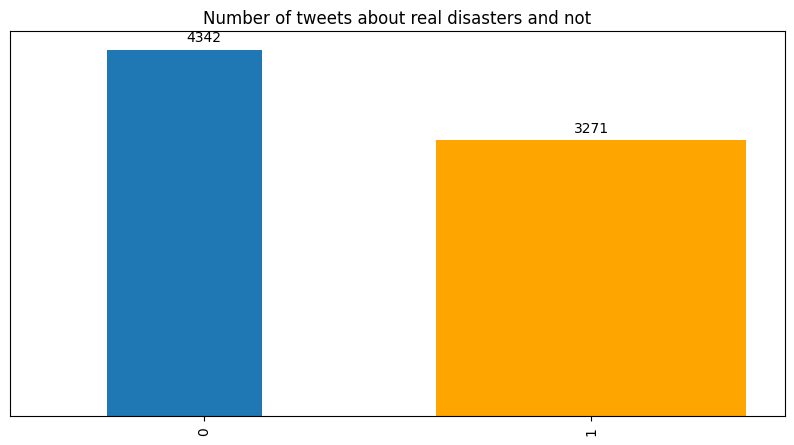

In [5]:
plt.figure(figsize=(10, 5))
data['target'].value_counts().plot(kind='bar')
plt.title('Number of tweets about real disasters and not')
# show value labels in the bars
for i, value in enumerate(data['target'].value_counts()):
    plt.text(i, value + 100, str(value), ha = 'center')
# change color of the bars 0: navy, 1: orange
plt.bar(1, data['target'].value_counts()[1], color='orange')
# delete y axis values
plt.gca().axes.get_yaxis().set_visible(False)
# set bar width
plt.gca().patches[0].set_width(0.4)
plt.gca().patches[1].set_width(0.4)
plt.show();

**1D. Top 10 keywords in the dataset and it's labels distribution**

<Figure size 1000x500 with 0 Axes>

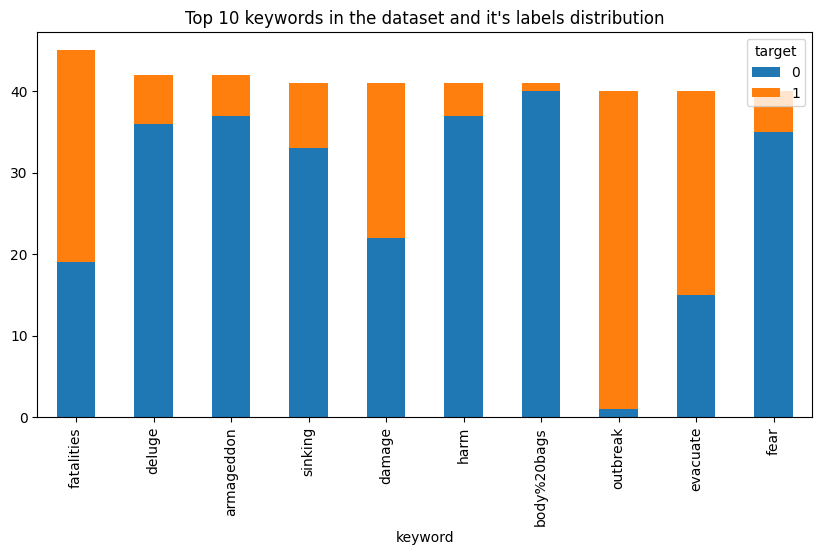

In [6]:
# Top 10 keywords in the dataset and it's labels distribution(stacked bar plot)
# 0: navy, 1: orange
plt.figure(figsize=(10, 5))
top_10_keywords = data.groupby(['keyword', 'target']).agg({'id': 'count'}).reset_index()
# unstack the data 'target' column
top_10_keywords = top_10_keywords.pivot(index='keyword', columns='target', values='id').reset_index()
top_10_keywords = top_10_keywords.fillna(0)
top_10_keywords['total'] = top_10_keywords[0] + top_10_keywords[1]
# sort the data by total descending and get the top 10
top_10_keywords = top_10_keywords.sort_values(by='total', ascending=False).head(10)
top_10_keywords.head()

# plot the data
top_10_keywords.plot(x='keyword', y=[0, 1], kind='bar', stacked=True, figsize=(10, 5))
plt.title('Top 10 keywords in the dataset and it\'s labels distribution')
plt.show();

**1D. Top 10 location in the dataset and it's labels distribution**

<Figure size 1000x500 with 0 Axes>

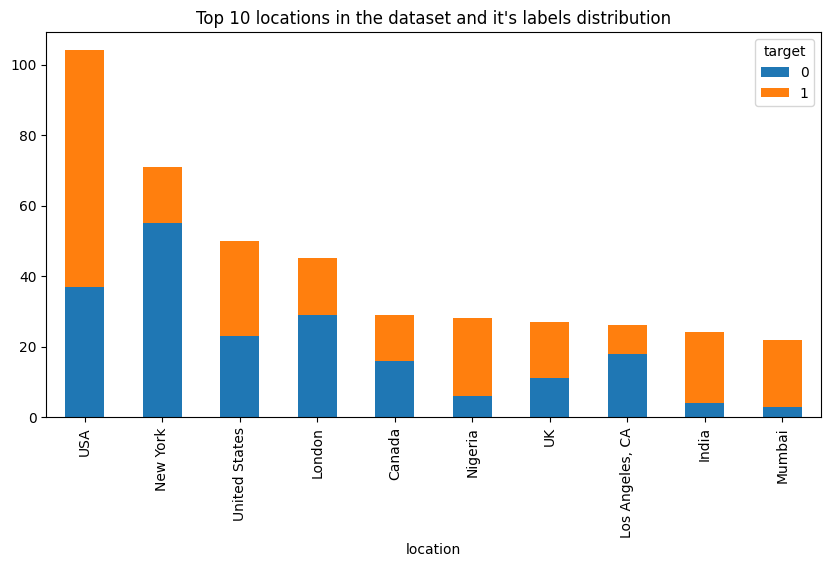

In [7]:
# Top 10 location in the dataset and it's labels distribution(stacked bar plot)
# 0: navy, 1: orange
plt.figure(figsize=(10, 5))
top_10_locations = data.groupby(['location', 'target']).agg({'id': 'count'}).reset_index()
# unstack the data 'target' column
top_10_locations = top_10_locations.pivot(index='location', columns='target', values='id').reset_index()
top_10_locations = top_10_locations.fillna(0)
top_10_locations['total'] = top_10_locations[0] + top_10_locations[1]
# sort the data by total descending and get the top 10
top_10_locations = top_10_locations.sort_values(by='total', ascending=False).head(10)
top_10_locations.head()

# plot the data
top_10_locations.plot(x='location', y=[0, 1], kind='bar', stacked=True, figsize=(10, 5))
plt.title('Top 10 locations in the dataset and it\'s labels distribution')
plt.show();

<Figure size 1000x500 with 0 Axes>

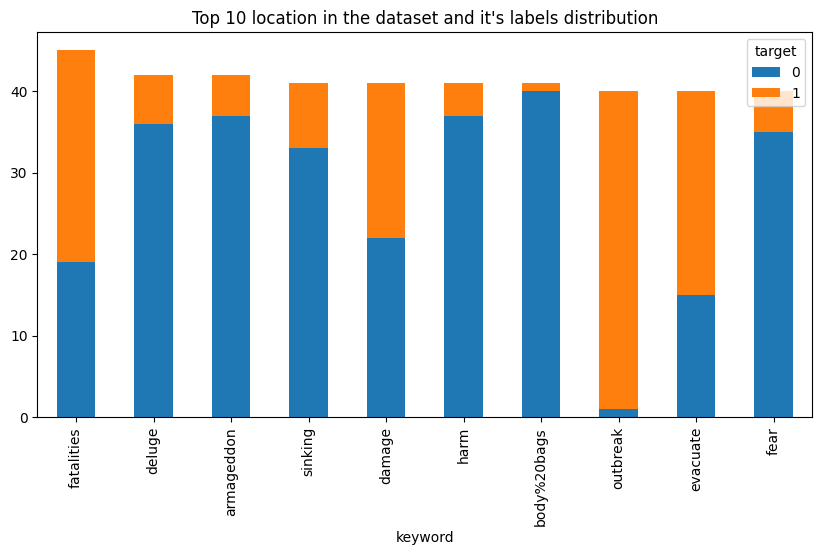

In [8]:
# Top 10 keywords in the dataset and it's labels distribution(stacked bar plot)
# 0: navy, 1: orange
plt.figure(figsize=(10, 5))
top_10_keywords = data.groupby(['keyword', 'target']).agg({'id': 'count'}).reset_index()
# unstack the data 'target' column
top_10_keywords = top_10_keywords.pivot(index='keyword', columns='target', values='id').reset_index()
top_10_keywords = top_10_keywords.fillna(0)
top_10_keywords['total'] = top_10_keywords[0] + top_10_keywords[1]
# sort the data by total descending and get the top 10
top_10_keywords = top_10_keywords.sort_values(by='total', ascending=False).head(10)
top_10_keywords.head()

# plot the data
top_10_keywords.plot(x='keyword', y=[0, 1], kind='bar', stacked=True, figsize=(10, 5))
plt.title('Top 10 location in the dataset and it\'s labels distribution')
plt.show();

**1E. Top 10 words in the dataset and it's labels distribution**

In the 'text' column, there is raw text data. 

In the cleaning process, we will also remove the stopwords, lemmatize the words, and correct the spelling mistakes.
We need to remove http links, punctuation, and numbers from the text data.

We will use the TfidfVectorizer to get the top 10 words in the dataset and it's labels distribution.

In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
spell = SpellChecker()

length = len(data['text'])

global i
i = 0

def preprocess_text(text):

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text.lower())

    # revome the starts with 'http' and 'www'
    words = [word for word in words if not word.startswith('http') and not word.startswith('www')]

    # replace simbols with '' using regex(only degits and letters)
    words = [re.sub(r'[^a-zA-Z0-9]', '', word) for word in words]

    # lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    # remove stop words
    lemmatized_words = [word for word in lemmatized_words if word not in stop_words]

    global i
    i += 1
    print(f'{i}/{length}')
    return ' '.join(lemmatized_words)

# preprocess the data
data['text_cleaned'] = data['text'].apply(lambda x: preprocess_text(str(x)) if isinstance(x, float) else preprocess_text(x))

# save the preprocessed data (it takes a long time to preprocess the data)
data.to_csv('preprocessed_data.csv', index=False)

1/7613
2/7613
3/7613
4/7613
5/7613
6/7613
7/7613
8/7613
9/7613
10/7613
11/7613
12/7613
13/7613
14/7613
15/7613
16/7613
17/7613
18/7613
19/7613
20/7613
21/7613
22/7613
23/7613
24/7613
25/7613
26/7613
27/7613
28/7613
29/7613
30/7613
31/7613
32/7613
33/7613
34/7613
35/7613
36/7613
37/7613
38/7613
39/7613
40/7613
41/7613
42/7613
43/7613
44/7613
45/7613
46/7613
47/7613
48/7613
49/7613
50/7613
51/7613
52/7613
53/7613
54/7613
55/7613
56/7613
57/7613
58/7613
59/7613
60/7613
61/7613
62/7613
63/7613
64/7613
65/7613
66/7613
67/7613
68/7613
69/7613
70/7613
71/7613
72/7613
73/7613
74/7613
75/7613
76/7613
77/7613
78/7613
79/7613
80/7613
81/7613
82/7613
83/7613
84/7613
85/7613
86/7613
87/7613
88/7613
89/7613
90/7613
91/7613
92/7613
93/7613
94/7613
95/7613
96/7613
97/7613
98/7613
99/7613
100/7613
101/7613
102/7613
103/7613
104/7613
105/7613
106/7613
107/7613
108/7613
109/7613
110/7613
111/7613
112/7613
113/7613
114/7613
115/7613
116/7613
117/7613
118/7613
119/7613
120/7613
121/7613
122/7613
123/7613
1

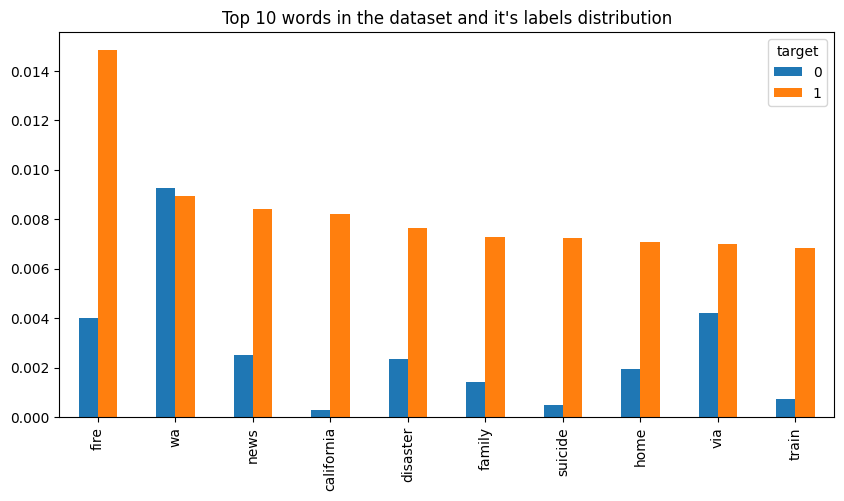

In [10]:
# Load preprocessed data
data = pd.read_csv('preprocessed_data.csv')

# TfidfVectorizer to get the top 10 words in the dataset and it's labels distribution.
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text_cleaned'])
X = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# get the top 10 words for each label
top_10_words = X.copy()
top_10_words['target'] = data['target']
top_10_words = top_10_words.groupby('target').mean().T

# sort the data by target 1 and get the top 10
top_10_words = top_10_words.sort_values(by=1, ascending=False).head(10)

# plot the data
top_10_words.plot(kind='bar', figsize=(10, 5))
plt.title('Top 10 words in the dataset and it\'s labels distribution')
plt.show();

---
## 2. Build a first LSTM model

Now, let's build a first LSTM model to predict whether a tweet is about a real disaster or not.

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to handle long-term dependencies in sequential data. LSTM networks have a “cell state” that retains information over long periods and “gate mechanisms” that control the flow of information. This allows LSTMs to retain important information for extended periods while forgetting irrelevant information, addressing the long-term dependency issues that traditional RNNs struggle with.

LSTMs are widely used in tasks involving sequential data, such as speech recognition, text generation, and machine translation. For instance, in speech recognition, LSTMs can predict the current phoneme based on past audio data. In text generation, they can predict the next word based on the previous sequence of words.

The basic structure of an LSTM includes three gates: the input gate, the forget gate, and the output gate, along with the cell state. The input gate adds new information to the cell state, the forget gate removes unnecessary information, and the output gate outputs information from the cell state. This structure enables LSTMs to learn long-term patterns and improve the accuracy of predictions in sequential data.


Before building the LSTM model, we need to split the data into training and testing sets.

Next we will transform the text data into numerical data using the TfidfVectorizer and OneHotEncoder.

Finally, we will build the LSTM model using TensorFlow and Keras.

**2A. Fillings missing values in the 'keyword' and 'location' columns and split the data into train and test sets.**

In [11]:
# split the data into train and test
data['keyword'].fillna('unknown', inplace=True)
data['location'].fillna('unknown', inplace=True)

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data[['text_cleaned', 'keyword', 'location']], data['target'], test_size=0.2, random_state=42)

**2B. Transforming the data using TfidfVectorizer and OneHotEncoder**

In [12]:
# Create one-hot encoders for keyword and location
keyword_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
location_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoders and vectorizer on the training data only
keyword_encoded_train = keyword_encoder.fit_transform(X_train['keyword'].values.reshape(-1, 1))
location_encoded_train = location_encoder.fit_transform(X_train['location'].values.reshape(-1, 1))

# Vectorization using TF-IDF for the text (fit on train, transform on both train and test)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', min_df=5)
X_train_text = vectorizer.fit_transform(X_train['text_cleaned']).toarray()

# Transform the test set using the fitted encoders and vectorizer
keyword_encoded_test = keyword_encoder.transform(X_test['keyword'].values.reshape(-1, 1))
location_encoded_test = location_encoder.transform(X_test['location'].values.reshape(-1, 1))
X_test_text = vectorizer.transform(X_test['text_cleaned']).toarray()

# Combine TF-IDF text features with keyword and location features for both train and test
X_train_combined = np.concatenate([X_train_text, keyword_encoded_train, location_encoded_train], axis=1)
X_test_combined = np.concatenate([X_test_text, keyword_encoded_test, location_encoded_test], axis=1)

# Reshape the data to be 3D for LSTM (samples, timesteps, features)
X_train_combined = X_train_combined.reshape(X_train_combined.shape[0], 1, X_train_combined.shape[1])
X_test_combined = X_test_combined.reshape(X_test_combined.shape[0], 1, X_test_combined.shape[1])

c:\Users\s-ohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\s-ohn\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**2C. Define the function to make check points and plot the loss and accuracy and create the model**

In [13]:
# Define the model checkpoint
def make_checkpoint(model_name):

    return ModelCheckpoint(filepath=f'best_{model_name}.h5',  # model filename
                           monitor='val_accuracy',  # quantity to monitor
                           mode='max',  # mode - maximize the quantity
                           save_best_only=True,  # save the best model
                           verbose=1)  # verbosity mode - 1: update messages

# Define the function of callback for early stopping
def early_stopping():
    
        return tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',  # quantity to monitor
                                                mode='max',  # mode - maximize the quantity
                                                patience=2,  # no of epochs with no improvement after which training will be stopped
                                                restore_best_weights=True)  # restore the best weights when stopped


# Define the function of ploting the training history
def plot_history(history):

    # rigth history for accuracy of train and validation
    # left history for loss of train and validation

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # summarize history for accuracy
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'validation'], loc='upper left')
    # change y-axis 0 to 1
    ax[0].set_ylim(0, 1)
    # set x-axis 0 to max epoch
    ax[0].set_xlim(0, 5)
    # set x-axis ticks to integers
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(len(history.history['accuracy']) + 1))

    # summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'validation'], loc='upper left')
    # change y-axis 0 to max value*1.1
    ax[1].set_ylim(0, max(max(history.history['loss']), max(history.history['val_loss'])) * 1.1)
    # set x-axis 0 to max epoch
    ax[1].set_xlim(0, 5)
    # set x-axis ticks to integers
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(len(history.history['accuracy']) + 1))

    # print the max validation accuracy and min validation loss and their epochs
    print(f"Max validation accuracy: {max(history.history['val_accuracy'])} at epoch {np.argmax(history.history['val_accuracy']) + 1}")
    print(f"Min validation loss: {min(history.history['val_loss'])} at epoch {np.argmin(history.history['val_loss']) + 1}")

    plt.show();


# define the function of building the model and training and ploting the history
def build_and_train_model(model, model_name, X_train, y_train, X_test, y_test, batch_size, learning_rate, epochs=10):

    # Adam optimizer with learning rate 0.0001
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # default learning rate is 0.001

    # compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # fit the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[make_checkpoint(model_name), early_stopping()])

    # plot the history
    plot_history(history)


**2D. Build and train a simple LSTM model**

Epoch 1/10
381/381 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.5745
Epoch 1: val_accuracy improved from -inf to 0.65135, saving model to best_LSTM.h5
381/381 [==============================] - 14s 29ms/step - loss: 0.6794 - accuracy: 0.5745 - val_loss: 0.6354 - val_accuracy: 0.6513
Epoch 2/10
  4/381 [..............................] - ETA: 8s - loss: 0.6123 - accuracy: 0.6562 

c:\Users\s-ohn\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


379/381 [============================>.] - ETA: 0s - loss: 0.5039 - accuracy: 0.7868
Epoch 2: val_accuracy improved from 0.65135 to 0.78792, saving model to best_LSTM.h5
381/381 [==============================] - 10s 27ms/step - loss: 0.5035 - accuracy: 0.7869 - val_loss: 0.4790 - val_accuracy: 0.7879
Epoch 3/10
379/381 [============================>.] - ETA: 0s - loss: 0.3613 - accuracy: 0.8484
Epoch 3: val_accuracy did not improve from 0.78792
381/381 [==============================] - 10s 27ms/step - loss: 0.3618 - accuracy: 0.8484 - val_loss: 0.4797 - val_accuracy: 0.7866
Epoch 4/10
381/381 [==============================] - ETA: 0s - loss: 0.3042 - accuracy: 0.8796
Epoch 4: val_accuracy improved from 0.78792 to 0.78923, saving model to best_LSTM.h5
381/381 [==============================] - 10s 27ms/step - loss: 0.3042 - accuracy: 0.8796 - val_loss: 0.4879 - val_accuracy: 0.7892
Epoch 5/10
379/381 [============================>.] - ETA: 0s - loss: 0.2577 - accuracy: 0.9044
Epoch 5

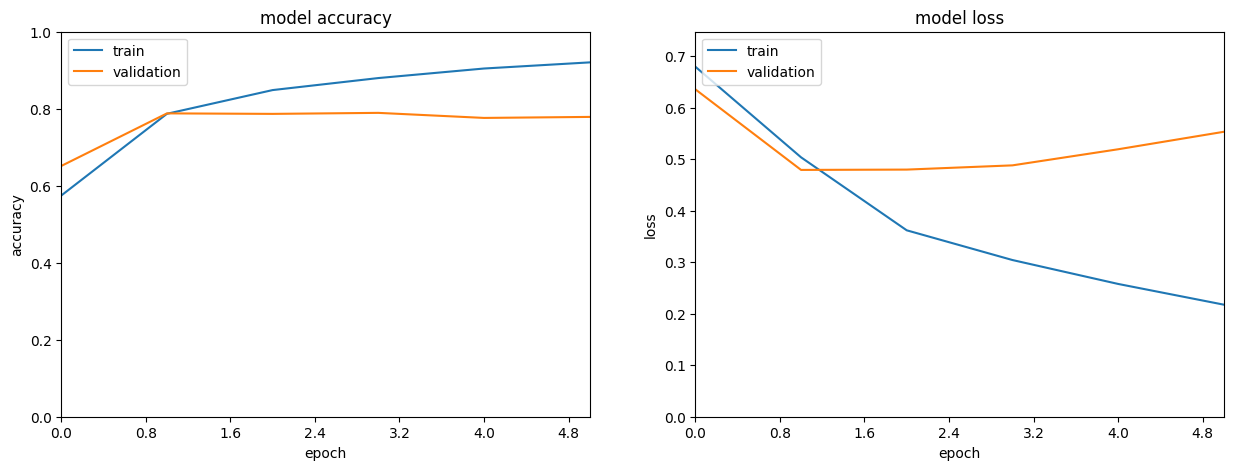

In [14]:
input_shape = ((X_train_combined.shape[1], X_train_combined.shape[2]))
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=input_shape, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Build and train the model
build_and_train_model(model, 'LSTM', X_train_combined, y_train, X_test_combined, y_test, batch_size=16, learning_rate=0.0001, epochs=10)

---
## 3. Build a anther models and compare the results

The validation accuracy of the LSTM model is approximately 0.8.
Let's try to build another LSTM model with a different architecture and compare the results.
Finary, we change the learning rate of the optimizer and how infulence the model accuracy.

**3A. GRU Model eith tf-idf**

Epoch 1/10
380/381 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.6018
Epoch 1: val_accuracy improved from -inf to 0.73145, saving model to best_GRU.h5
381/381 [==============================] - 11s 21ms/step - loss: 0.6647 - accuracy: 0.6018 - val_loss: 0.5853 - val_accuracy: 0.7315
Epoch 2/10
380/381 [============================>.] - ETA: 0s - loss: 0.4437 - accuracy: 0.8133
Epoch 2: val_accuracy improved from 0.73145 to 0.79317, saving model to best_GRU.h5
381/381 [==============================] - 8s 20ms/step - loss: 0.4437 - accuracy: 0.8135 - val_loss: 0.4702 - val_accuracy: 0.7932
Epoch 3/10
379/381 [============================>.] - ETA: 0s - loss: 0.3366 - accuracy: 0.8590
Epoch 3: val_accuracy did not improve from 0.79317
381/381 [==============================] - 8s 20ms/step - loss: 0.3366 - accuracy: 0.8589 - val_loss: 0.4750 - val_accuracy: 0.7905
Epoch 4/10
381/381 [==============================] - ETA: 0s - loss: 0.2786 - accuracy: 0.8888
Epo

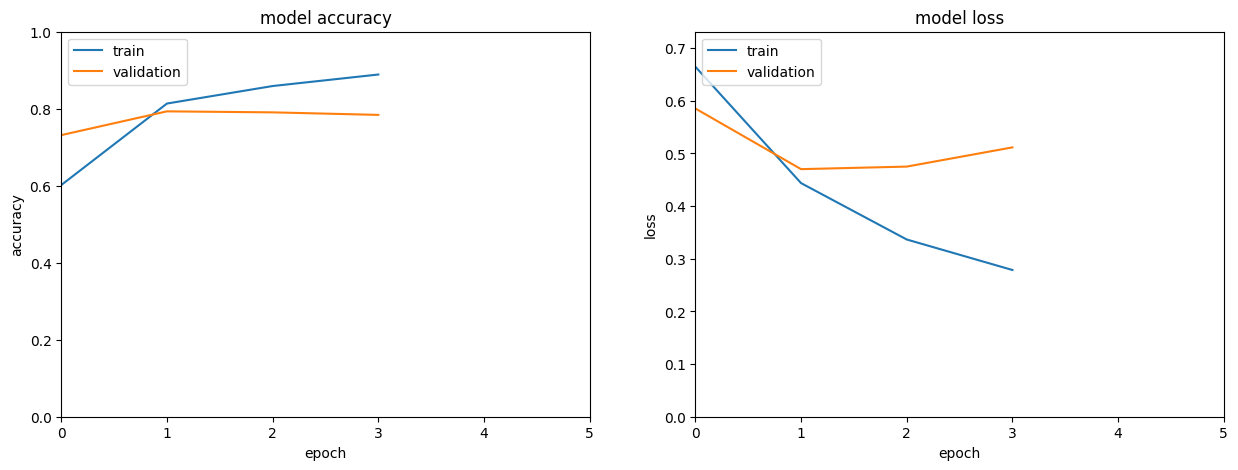

In [15]:
# GRU model
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, input_shape=input_shape, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Build and train the model
build_and_train_model(model, 'GRU', X_train_combined, y_train, X_test_combined, y_test, batch_size=16, learning_rate=0.0001, epochs=10)

**3B. Bidirectional LSTM with tf-idf**

Epoch 1/10
380/381 [============================>.] - ETA: 0s - loss: 0.5798 - accuracy: 0.6982
Epoch 1: val_accuracy improved from -inf to 0.78661, saving model to best_Bidirectional_LSTM.h5
381/381 [==============================] - 21s 50ms/step - loss: 0.5792 - accuracy: 0.6987 - val_loss: 0.6062 - val_accuracy: 0.7866
Epoch 2/10
381/381 [==============================] - ETA: 0s - loss: 0.3951 - accuracy: 0.8317
Epoch 2: val_accuracy improved from 0.78661 to 0.79580, saving model to best_Bidirectional_LSTM.h5
381/381 [==============================] - 19s 49ms/step - loss: 0.3951 - accuracy: 0.8317 - val_loss: 0.4651 - val_accuracy: 0.7958
Epoch 3/10
381/381 [==============================] - ETA: 0s - loss: 0.3021 - accuracy: 0.8806
Epoch 3: val_accuracy did not improve from 0.79580
381/381 [==============================] - 19s 49ms/step - loss: 0.3021 - accuracy: 0.8806 - val_loss: 0.4712 - val_accuracy: 0.7925
Epoch 4/10
381/381 [==============================] - ETA: 0s - los

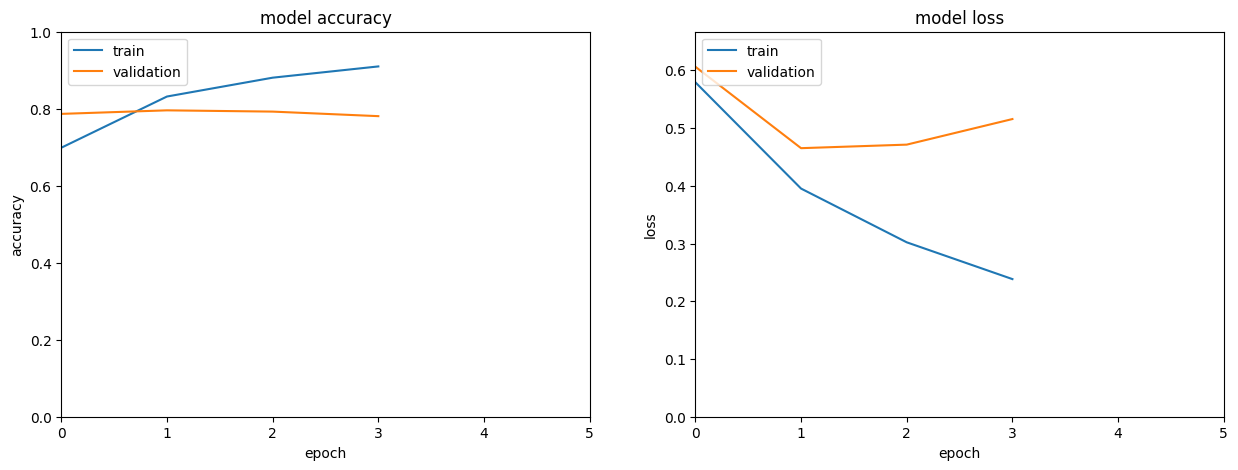

In [16]:
# bidirectional RNN model
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128), input_shape=input_shape),
    tf.keras.layers.Dense(64, activation='relu'),
    # normalize the output
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Build and train the model
build_and_train_model(model, 'Bidirectional_LSTM', X_train_combined, y_train, X_test_combined, y_test, batch_size=16, learning_rate=0.0001, epochs=10)

The accuracy of the 3 above models looks like have the same accuracy and loss.
How can I improve the accuracy of the model?
To change learing rate, batch size, activation function, the accuracy may be improved?
In this project, I change learing rate.
Let's look at the accuracy of the model after changing the learning rate.

Epoch 1/10
381/381 [==============================] - ETA: 0s - loss: 0.5150 - accuracy: 0.7545
Epoch 1: val_accuracy improved from -inf to 0.78661, saving model to best_Bidirectional_LSTM.h5
381/381 [==============================] - 21s 51ms/step - loss: 0.5150 - accuracy: 0.7545 - val_loss: 0.4676 - val_accuracy: 0.7866
Epoch 2/10
381/381 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8606
Epoch 2: val_accuracy improved from 0.78661 to 0.78726, saving model to best_Bidirectional_LSTM.h5
381/381 [==============================] - 19s 50ms/step - loss: 0.3243 - accuracy: 0.8606 - val_loss: 0.4972 - val_accuracy: 0.7873
Epoch 3/10
381/381 [==============================] - ETA: 0s - loss: 0.2222 - accuracy: 0.9066
Epoch 3: val_accuracy did not improve from 0.78726
381/381 [==============================] - 19s 49ms/step - loss: 0.2222 - accuracy: 0.9066 - val_loss: 0.5801 - val_accuracy: 0.7708
Epoch 4/10
380/381 [============================>.] - ETA: 0s - los

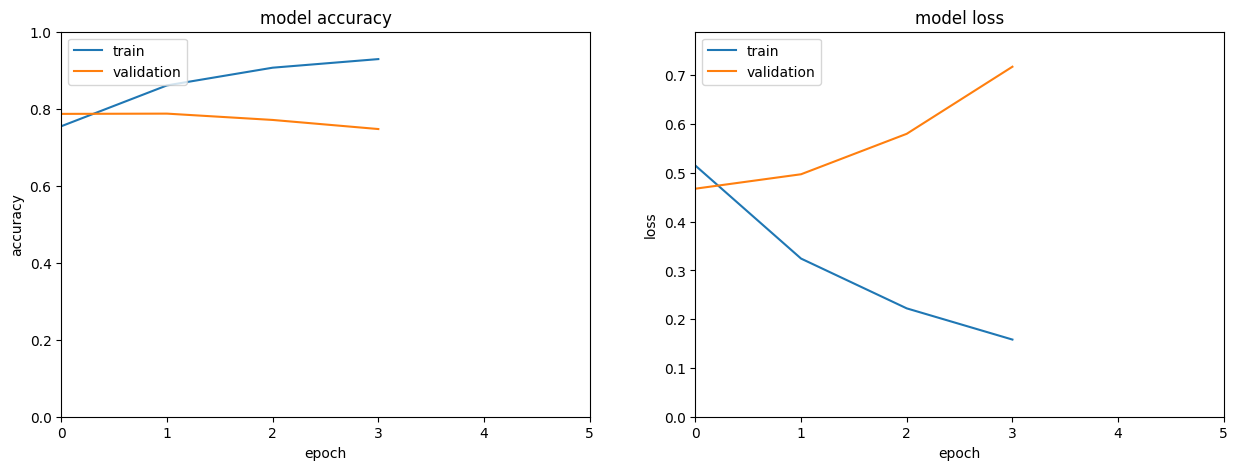

In [17]:
# when learning rate is 0.001(default)
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128), input_shape=input_shape),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Build and train the model
build_and_train_model(model, 'Bidirectional_LSTM', X_train_combined, y_train, X_test_combined, y_test, batch_size=16, learning_rate=0.001, epochs=10)


Epoch 1/10
381/381 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.8138
Epoch 1: val_accuracy improved from -inf to 0.78135, saving model to best_Bidirectional_LSTM.h5
381/381 [==============================] - 23s 54ms/step - loss: 0.4235 - accuracy: 0.8138 - val_loss: 0.4827 - val_accuracy: 0.7814
Epoch 2/10
381/381 [==============================] - ETA: 0s - loss: 0.2745 - accuracy: 0.8772
Epoch 2: val_accuracy did not improve from 0.78135
381/381 [==============================] - 21s 54ms/step - loss: 0.2745 - accuracy: 0.8772 - val_loss: 0.5664 - val_accuracy: 0.7643
Epoch 3/10
380/381 [============================>.] - ETA: 0s - loss: 0.1785 - accuracy: 0.9232
Epoch 3: val_accuracy did not improve from 0.78135
381/381 [==============================] - 20s 52ms/step - loss: 0.1784 - accuracy: 0.9233 - val_loss: 0.7152 - val_accuracy: 0.7485
Max validation accuracy: 0.7813525795936584 at epoch 1
Min validation loss: 0.4827391803264618 at epoch 1


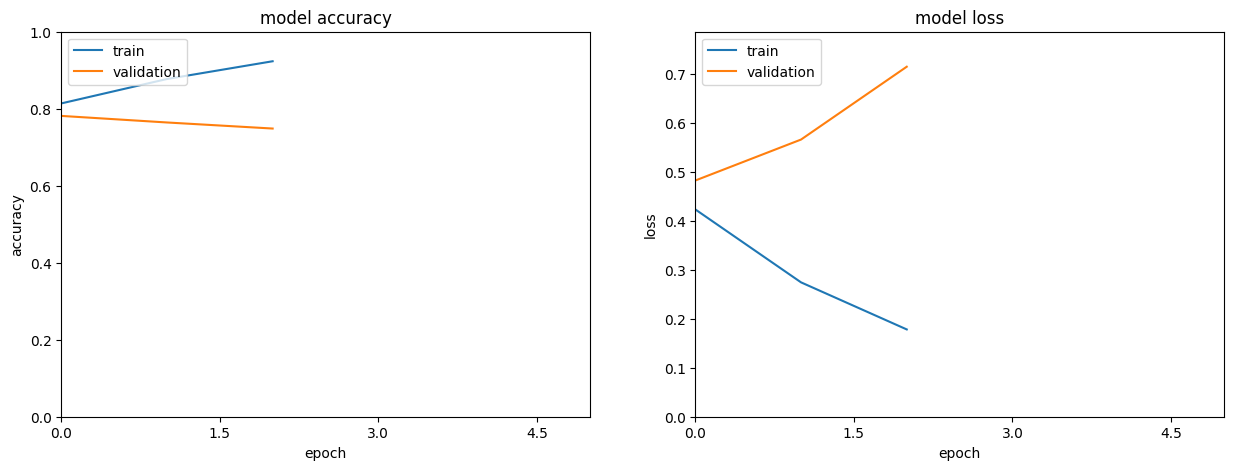

In [18]:
# when learning rate is 0.01
# Build and train the model
build_and_train_model(model, 'Bidirectional_LSTM', X_train_combined, y_train, X_test_combined, y_test, batch_size=16, learning_rate=0.01, epochs=10)


Epoch 1/10
380/381 [============================>.] - ETA: 0s - loss: 0.2881 - accuracy: 0.8933
Epoch 1: val_accuracy improved from -inf to 0.78267, saving model to best_Bidirectional_LSTM.h5
381/381 [==============================] - 23s 54ms/step - loss: 0.2881 - accuracy: 0.8933 - val_loss: 0.4828 - val_accuracy: 0.7827
Epoch 2/10
380/381 [============================>.] - ETA: 0s - loss: 0.2796 - accuracy: 0.8929
Epoch 2: val_accuracy improved from 0.78267 to 0.78398, saving model to best_Bidirectional_LSTM.h5
381/381 [==============================] - 20s 52ms/step - loss: 0.2796 - accuracy: 0.8931 - val_loss: 0.4836 - val_accuracy: 0.7840
Epoch 3/10
380/381 [============================>.] - ETA: 0s - loss: 0.2720 - accuracy: 0.8938
Epoch 3: val_accuracy improved from 0.78398 to 0.78529, saving model to best_Bidirectional_LSTM.h5
381/381 [==============================] - 19s 50ms/step - loss: 0.2720 - accuracy: 0.8938 - val_loss: 0.4851 - val_accuracy: 0.7853
Epoch 4/10
381/381 

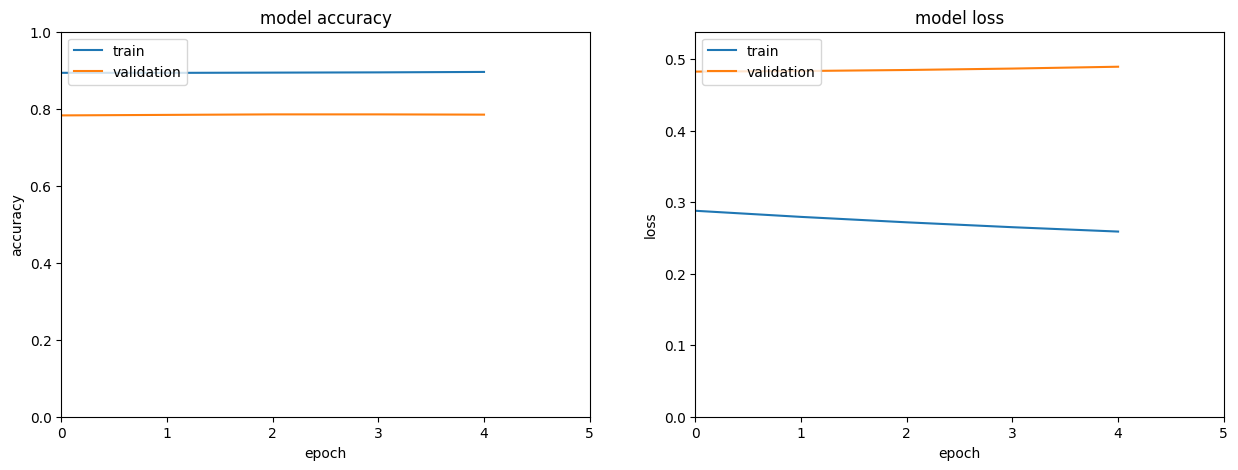

In [19]:
# when learning rate is 0.00001
# Build and train the model
build_and_train_model(model, 'Bidirectional_LSTM', X_train_combined, y_train, X_test_combined, y_test, batch_size=16, learning_rate=0.00001, epochs=10)

To change the learning rate, it affects big on the model. 
The best learning rate is 0.0001.

## 4. Conclusion

The best model is Bidirectional_LSTM with learning rate 0.0001 and batch size 16. But accuracy is neary 0.8, so it is not good enough.

To improve the model, it may be better to use the pre-trained model like BERT, GPT-2, etc. These models are used to solve the NLP and incorporated into the generative AI model.

atherwise, to chane the data preprocessing may be helpful.

I can't find way to improve the model with the current data and model.

So, Let's predict the test data and submit to Kaggle using the best model.

In [20]:
# load test data and preprocess it
test_data = pd.read_csv('test.csv')
test_data['text_cleaned'] = test_data['text'].apply(lambda x: preprocess_text(str(x)) if isinstance(x, float) else preprocess_text(x))

# Transform the test set using the fitted encoders and vectorizer
keyword_encoded_test = keyword_encoder.transform(test_data['keyword'].values.reshape(-1, 1))
location_encoded_test = location_encoder.transform(test_data['location'].values.reshape(-1, 1))
X_test_text = vectorizer.transform(test_data['text_cleaned']).toarray()

# Combine TF-IDF text features with keyword and location features for both train and test
X_test_combined = np.concatenate([X_test_text, keyword_encoded_test, location_encoded_test], axis=1)

# Reshape the data to be 3D for LSTM (samples, timesteps, features)
X_test_combined = X_test_combined.reshape(X_test_combined.shape[0], 1, X_test_combined.shape[1])

# Load the best model
model = tf.keras.models.load_model('best_Bidirectional_LSTM.h5')

# Predict the test data
y_pred = model.predict(X_test_combined)

# Convert the predictions to binary
y_pred = np.round(y_pred).astype(int)

# Create a submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': y_pred.flatten()})

# Save the submission file
submission.to_csv('submission.csv', index=False)

7614/7613
7615/7613
7616/7613
7617/7613
7618/7613
7619/7613
7620/7613
7621/7613
7622/7613
7623/7613
7624/7613
7625/7613
7626/7613
7627/7613
7628/7613
7629/7613
7630/7613
7631/7613
7632/7613
7633/7613
7634/7613
7635/7613
7636/7613
7637/7613
7638/7613
7639/7613
7640/7613
7641/7613
7642/7613
7643/7613
7644/7613
7645/7613
7646/7613
7647/7613
7648/7613
7649/7613
7650/7613
7651/7613
7652/7613
7653/7613
7654/7613
7655/7613
7656/7613
7657/7613
7658/7613
7659/7613
7660/7613
7661/7613
7662/7613
7663/7613
7664/7613
7665/7613
7666/7613
7667/7613
7668/7613
7669/7613
7670/7613
7671/7613
7672/7613
7673/7613
7674/7613
7675/7613
7676/7613
7677/7613
7678/7613
7679/7613
7680/7613
7681/7613
7682/7613
7683/7613
7684/7613
7685/7613
7686/7613
7687/7613
7688/7613
7689/7613
7690/7613
7691/7613
7692/7613
7693/7613
7694/7613
7695/7613
7696/7613
7697/7613
7698/7613
7699/7613
7700/7613
7701/7613
7702/7613
7703/7613
7704/7613
7705/7613
7706/7613
7707/7613
7708/7613
7709/7613
7710/7613
7711/7613
7712/7613
7713/7613


In [22]:
# Load the submission file and check the first few rows
submission = pd.read_csv('submission.csv')
print(submission.head())
print(len(submission))

   id  target
0   0       1
1   2       1
2   3       0
3   9       1
4  11       1
3263
